<h1> Predictive Maintainance MVP

Train an XgBoost model to predict whether a part is faulty or not in assembly line for predictive maintainance. Once the faulty part is found, it will be removed from the line and taken for repair.

<h2> Data Ingest from S3

In [130]:
import sagemaker
import numpy as np
import os
import json

sagemaker_session = sagemaker.Session()
bucket = 'stefan-mb-bucket'
role = sagemaker.get_execution_role()

In [133]:
role

'arn:aws:iam::389535300735:role/service-role/AmazonSageMaker-ExecutionRole-20190702T143831'

In [131]:
xgb_upload_location = os.path.join('s3://{}/{}'.format(bucket, 'xgb'))
print(xgb_upload_location)

s3://stefan-mb-bucket/xgb


In [132]:
# Grab the XGBoost container
region = 'us-east-1'
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost')
print(container)

811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1


In [86]:
# specify input for trianing xgboost model
prefix = 'training_data'
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}'.format(bucket, prefix), content_type='csv')
s3_input_train

In [6]:
# check the data
DATANAME = 'mbdataset.csv'
import pandas as pd
dat = pd.read_csv('s3://{}/{}/{}'.format(bucket, prefix, DATANAME))

In [7]:
dat.head()

,0,-0.14,-0.146,0.33,0.312,0.07400000000000001,0.161,0.052000000000000005,0.248,0.09699999999999999,...,0.0.119,0.0.120,0.0.121,0.0.122,0.0.123,0.0.124,0.0.125,0.0.126,0.0.127,0.0.128
0,0,-0.193,-0.213,-0.215,-0.161,0.118,-0.021,0.030,0.128,-0.148,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0,-0.068,-0.064,-0.033,-0.034,0.118,-0.294,0.015,0.048,-0.138,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.033,0.016,0.02,0.018,-0.173,-0.002,-0.067,-0.004,0.104,-0.099
3,0,-0.147,-0.205,-0.015,-0.016,0.074,0.161,0.030,0.168,-0.056,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [8]:
with open('cols.txt', 'r') as f:
    cols = json.load(f)

In [9]:
datorig = pd.read_csv('s3://{}/{}/{}'.format(bucket, prefix, DATANAME), names = cols)

In [153]:
datorig.head(20)

,Response,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L0_S23_F635,L0_S23_F639,L0_S23_F643,L0_S23_F647,L0_S23_F651,L0_S23_F655,L0_S23_F659,L0_S23_F663,L0_S23_F667,L0_S23_F671
0,0,-0.140,-0.146,0.330,0.312,0.074,0.161,0.052,0.248,0.097,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0,-0.193,-0.213,-0.215,-0.161,0.118,-0.021,0.030,0.128,-0.148,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0,-0.068,-0.064,-0.033,-0.034,0.118,-0.294,0.015,0.048,-0.138,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.033,0.016,0.020,0.018,-0.173,-0.002,-0.067,-0.004,0.104,-0.099
4,0,-0.147,-0.205,-0.015,-0.016,0.074,0.161,0.030,0.168,-0.056,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0,0.154,0.116,0.312,0.294,0.074,-0.475,-0.015,0.008,-0.133,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0,-0.055,0.108,-0.015,0.003,-0.013,0.116,0.015,-0.072,0.163,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0,-0.134,-0.131,-0.197,-0.161,0.118,0.206,0.022,0.088,-0.061,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


<h2> Data Exploration

In [11]:
import seaborn as sns

Percent of Faulty Examples = 10.063291139240507%


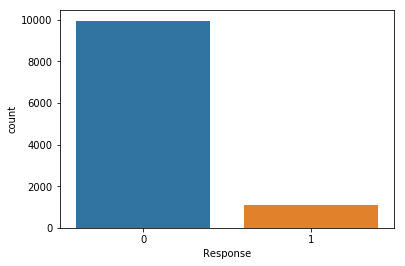

In [12]:
sns.countplot(datorig.Response)
print("Percent of Faulty Examples = {}%".format(len(datorig[datorig['Response']==1])/len(datorig)*100))

In [13]:
corr = datorig.corr()

In [39]:
index_list = list(corr['Response'].dropna().index)
val_list = np.argsort(np.abs(corr['Response'].dropna().values))[::-1]

Text(0, 0.5, 'Correlation')

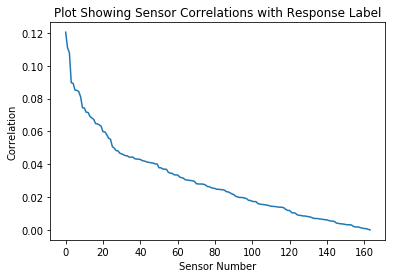

In [150]:
import matplotlib.pyplot as plt

plt.plot(np.sort(np.abs(corr['Response'].dropna().values))[::-1][1:])
plt.title("Plot Showing Sensor Correlations with Response Label")
plt.xlabel('Sensor Number')
plt.ylabel('Correlation')

In [46]:
# Get most corelated variables to the label.
top_corrs = [index_list[x] for x in val_list[:5]]
top_corrs

['Response', 'L0_S11_F318', 'L0_S11_F306', 'L0_S5_F114', 'L0_S5_F116']

In [47]:
reduceddat = datorig[top_corrs]
reduceddat.head()

,Response,L0_S11_F318,L0_S11_F306,L0_S5_F114,L0_S5_F116
0,0,0.000,0.000,0.186,-0.185
1,0,0.000,0.000,-0.029,-0.081
2,0,-0.025,-0.011,0.000,0.000
3,0,0.000,0.000,0.000,0.000
4,0,-0.042,-0.094,-0.145,-0.015


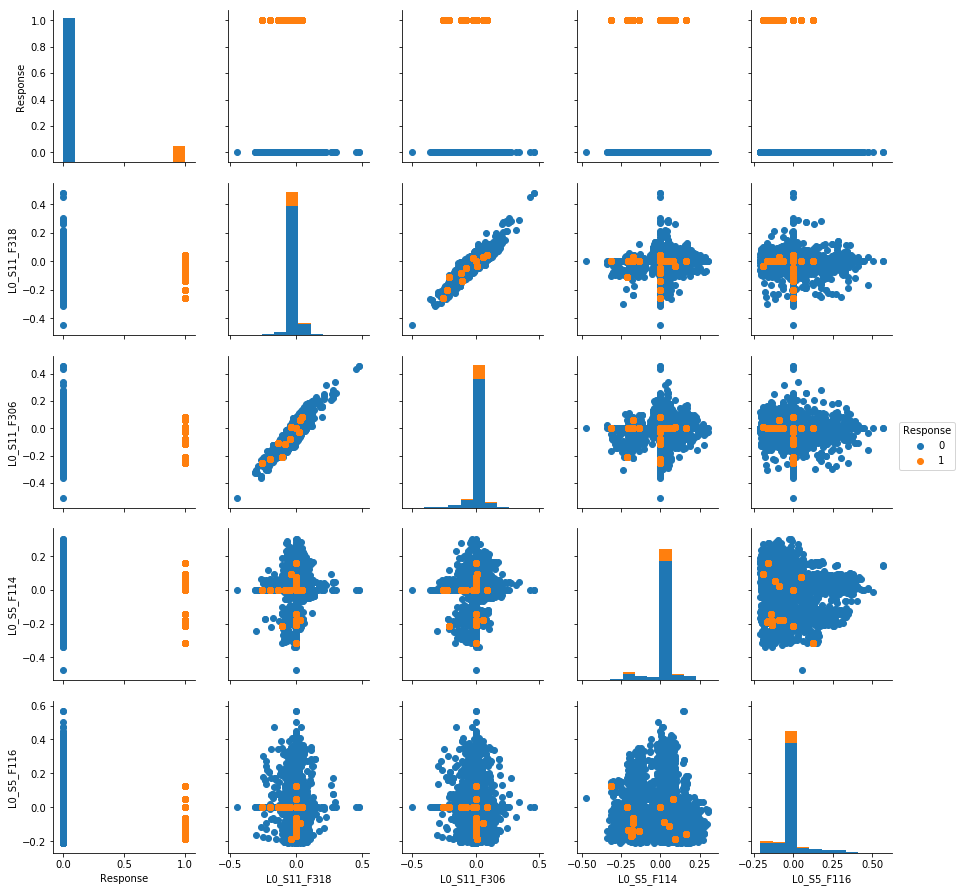

In [52]:
import matplotlib.pyplot as plt
g = sns.PairGrid(reduceddat, hue="Response")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()
plt.show()

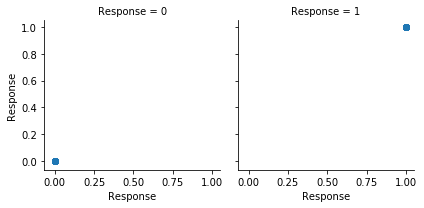

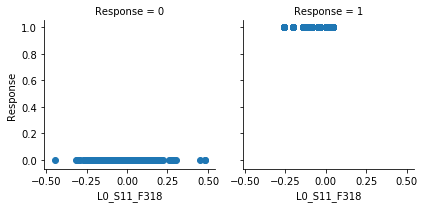

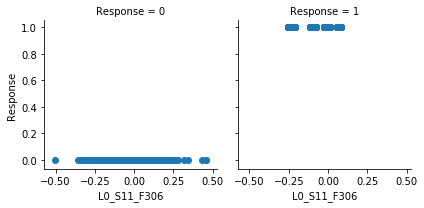

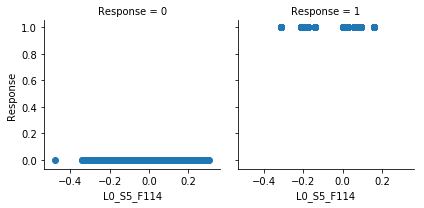

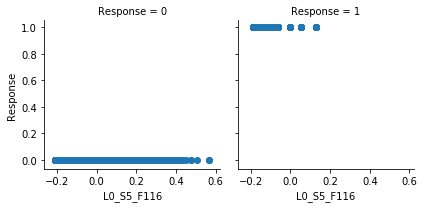

In [68]:
for item in top_corrs:
    g = sns.FacetGrid(datorig, col="Response")
    g.map(plt.scatter, item, 'Response')
    plt.show()

<h2> Model Training and Deployment

In [87]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c4.8xlarge',
                                    output_path=xgb_upload_location,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_train})

2019-07-26 15:21:18 Starting - Starting the training job...
2019-07-26 15:21:20 Starting - Launching requested ML instances......
2019-07-26 15:22:23 Starting - Preparing the instances for training......
2019-07-26 15:23:39 Downloading - Downloading input data
2019-07-26 15:23:39 Training - Downloading the training image..
Arguments: train
[2019-07-26:15:23:55:INFO] Running standalone xgboost training.
[2019-07-26:15:23:55:INFO] File size need to be processed in the node: 18.53mb. Available memory size in the node: 52286.48mb
[2019-07-26:15:23:55:INFO] Determined delimiter of CSV input is ','
[15:23:55] S3DistributionType set as FullyReplicated
[15:23:55] 11060x168 matrix with 1858080 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-07-26:15:23:55:INFO] Determined delimiter of CSV input is ','
[15:23:55] S3DistributionType set as FullyReplicated
[15:23:55] 11060x168 matrix with 1858080 entries loaded from /opt/ml/input/data/validation?format=csv&


2019-07-26 15:24:07 Uploading - Uploading generated training model
2019-07-26 15:24:07 Completed - Training job completed
Billable seconds: 40


In [ ]:
# deploy the trained model
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

----------------------------------------

<h2> Predictions and Model Performance

In [75]:
# check that you can run inferences on the model
from sagemaker.predictor import csv_serializer
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

NameError: name 'xgb_predictor' is not defined

In [91]:
# Run a prediction
array = np.array(dat.iloc[:5,1:])
#f = lambda x: np.round(x)
#res = np.fromstring(xgb_predictor.predict(array).decode('utf-8'), sep = ',')
#f(res)

In [22]:
with open('cols.txt', 'w') as f:
    json.dump(cols, f)

In [102]:
csv_text = ' '.join([str(x) for x in array[0]])
#''.join([x for x in array[0]])

In [103]:
### Invoke the endpoint
import boto3
import json
 
endpoint = 'xgboost-2019-07-03-15-05-21-683'
 
runtime = boto3.Session().client('sagemaker-runtime')
 
# Send CSV text via InvokeEndpoint API
response = runtime.invoke_endpoint(EndpointName=endpoint, ContentType='text/csv', Body=csv_text)
# Unpack response
print(response)
result = json.loads(response['Body'].read().decode())
int(np.round(result))

{'ResponseMetadata': {'RequestId': 'a2a449c6-d69d-420f-a6ba-760aa0669d14', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'a2a449c6-d69d-420f-a6ba-760aa0669d14', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Fri, 26 Jul 2019 15:26:12 GMT', 'content-type': 'text/csv; charset=utf-8', 'content-length': '17'}, 'RetryAttempts': 0}, 'ContentType': 'text/csv; charset=utf-8', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7f8eb44739e8>}


0

<h2> Batch Transform 

Code to perform batch inference on a regular basis whenever new data comes in from the Kinesis Stream into S3

In [104]:
# Create a test dataset identical to the training set
test_set = dat.drop(columns = ['0'])
test_set.to_csv('mbtest.csv', index =False, header = False)

In [105]:
test_loc = sess.upload_data('mbtest.csv', bucket=bucket,key_prefix=prefix)

In [107]:
batch_input = 's3://{}/{}'.format(bucket, prefix) # The location of the test dataset

batch_output = 's3://{}/{}/batch-inference'.format(bucket, prefix) # The location to store the results of the batch transform job

transformer = xgb.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)

transformer.transform(data=batch_input, data_type='S3Prefix', content_type='text/csv', split_type='Line')

transformer.wait()

Using already existing model: xgboost-2019-07-26-15-21-18-785


...........................................*


ValueError: Error for Transform job xgboost-2019-07-26-15-46-00-740: Failed Reason: ClientError: See job logs for more information

In [108]:
transformer.output_path

's3://stefan-mb-bucket/training_data/batch-inference'

In [109]:
data_dir = './data/inference'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

!aws s3 cp --recursive $transformer.output_path $data_dir

download: s3://stefan-mb-bucket/training_data/batch-inference/mbtest.csv.out to data/inference/mbtest.csv.out


In [114]:
y_test = pd.read_csv(os.path.join(data_dir, 'mbtest.csv.out'), header=None)
resp = datorig['Response']
y_vals = np.round(y_test.values)

In [127]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [122]:
print("Model Accuracy = {} %".format(accuracy_score(resp.values[1:], y_vals)*100))

Model Accuracy = 96.44633330319196 %


In [129]:
print(classification_report(resp.values[1:], y_vals))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9946
           1       0.98      0.66      0.79      1113

   micro avg       0.96      0.96      0.96     11059
   macro avg       0.97      0.83      0.88     11059
weighted avg       0.97      0.96      0.96     11059



Confusion matrix, without normalization
[[9931   15]
 [ 378  735]]


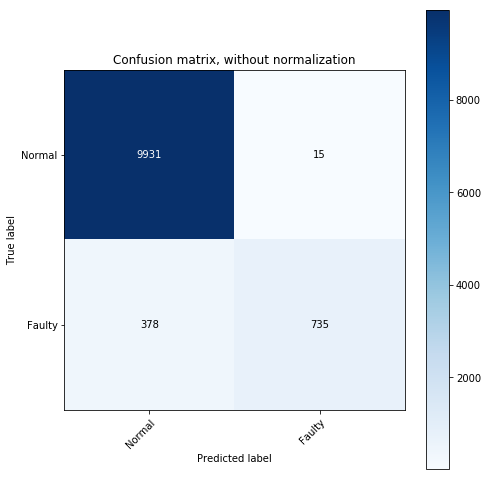

In [162]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize = (7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(resp.values[1:], y_vals, classes=['Normal', 'Faulty'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.show()